In [9]:
from dotenv import load_dotenv

load_dotenv()

import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import json
from probe_dataset import ReadingProbeDataset
import sklearn.model_selection
from torch.utils.data import Subset
from torch.utils.data.dataloader import DataLoader
import pickle
from tqdm.auto import tqdm
from probes import LinearProbeClassification, TrainerConfig
from train_test_utils import train, test
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [10]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"

# MODEL_NAME = "Qwen/Qwen3-4B"
MODEL_NAME = "meta-llama/Llama-2-13b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, device_map=device, token=os.getenv("HUGGINGFACE_API_KEY")
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map=device, token=os.getenv("HUGGINGFACE_API_KEY")
)
model.half().cuda()
model.eval()

Loading checkpoint shards: 100%|██████████| 3/3 [00:12<00:00,  4.02s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((5120,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((5120,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((5120,), eps=1e-05)
    (rotary_e

In [11]:
COLOR = "red"

dataset = ReadingProbeDataset(
    directory="data/gemini_v2/",
    model=model,
    tokenizer=tokenizer,
	control_probe=True,
	color=COLOR
)

Loading data: 100%|██████████| 615/615 [07:43<00:00,  1.33it/s]


In [12]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
print(f"Train size: {train_size}, Test size: {test_size}")

train_idx, val_idx = sklearn.model_selection.train_test_split(
    list(range(len(dataset))),
    test_size=test_size,
    train_size=train_size,
    random_state=12345,
    shuffle=True,
    stratify=dataset.labels,
)

print(f"Train idx: {train_idx}")
print(f"Val idx: {val_idx}")

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, val_idx)

Train size: 461, Test size: 154
Train idx: [499, 104, 557, 606, 518, 170, 46, 216, 187, 179, 74, 242, 374, 132, 538, 42, 178, 240, 405, 4, 248, 223, 20, 410, 128, 420, 166, 109, 256, 477, 127, 505, 384, 245, 30, 0, 70, 226, 570, 527, 83, 293, 485, 57, 583, 123, 155, 533, 7, 521, 431, 396, 282, 5, 84, 140, 391, 427, 322, 469, 189, 228, 145, 285, 364, 331, 299, 380, 422, 263, 208, 487, 103, 289, 106, 479, 261, 496, 136, 12, 438, 428, 92, 105, 328, 56, 1, 62, 541, 75, 168, 254, 286, 463, 308, 426, 409, 511, 509, 262, 278, 404, 235, 500, 318, 340, 596, 421, 214, 13, 389, 466, 267, 53, 298, 483, 126, 296, 603, 370, 480, 399, 258, 40, 287, 454, 394, 474, 244, 91, 94, 455, 388, 52, 575, 87, 502, 43, 565, 497, 508, 193, 379, 586, 160, 281, 569, 349, 65, 114, 186, 352, 468, 608, 381, 146, 343, 594, 489, 464, 503, 88, 17, 386, 418, 591, 501, 139, 190, 213, 470, 316, 257, 462, 294, 545, 63, 162, 423, 143, 360, 14, 141, 61, 317, 236, 36, 481, 59, 221, 601, 589, 493, 154, 54, 402, 266, 218, 562, 27

In [13]:
sampler = None
train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    sampler=sampler,
    pin_memory=True,
    batch_size=200,
    num_workers=1,
)
test_loader = DataLoader(
    test_dataset, shuffle=False, pin_memory=True, batch_size=400, num_workers=1
)

In [14]:
loss_func = nn.BCELoss()

accuracy_dict = {}

dict_name = f"{COLOR}_control_probe"

accuracy_dict[dict_name] = []
accuracy_dict[dict_name + "_final"] = []
accuracy_dict[dict_name + "_train"] = []

Training layers:   0%|          | 0/41 [00:00<?, ?it/s]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 0----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.6698 (0.524 sec) Accuracy: 0.651



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.6688,  Accuracy: 0.649



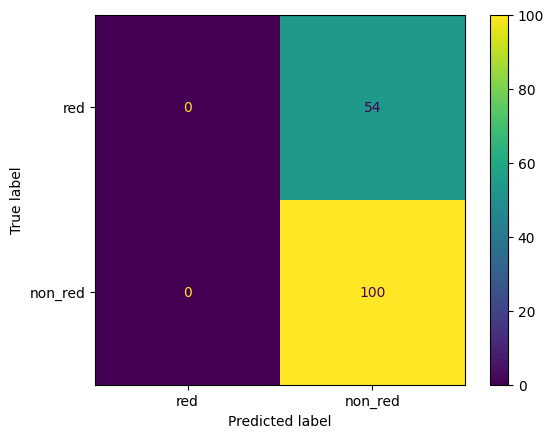

Training layers:   2%|▏         | 1/41 [00:44<29:29, 44.23s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 1----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.6576 (0.507 sec) Accuracy: 0.664



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.6424,  Accuracy: 0.643



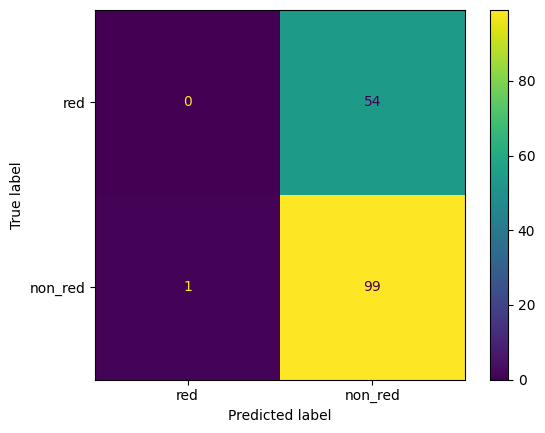

Training layers:   5%|▍         | 2/41 [01:26<28:09, 43.32s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 2----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 16.6414 (0.500 sec) Accuracy: 0.653



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6524,  Accuracy: 0.669



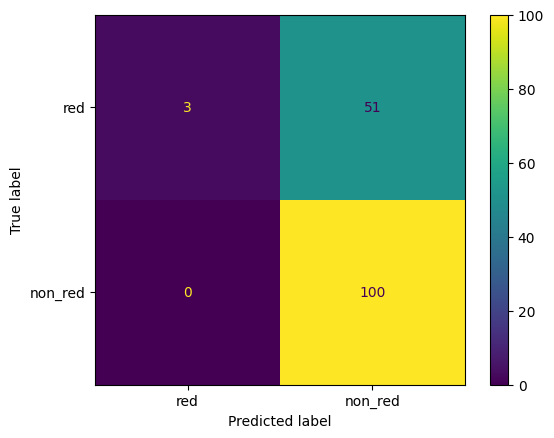

Training layers:   7%|▋         | 3/41 [02:09<27:14, 43.02s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 3----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 48.3319 (0.516 sec) Accuracy: 0.364



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 46.7997,  Accuracy: 0.325



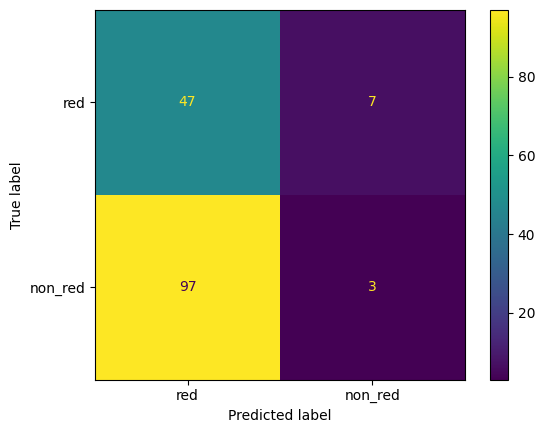

Training layers:  10%|▉         | 4/41 [02:52<26:32, 43.04s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 4----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.7177 (0.546 sec) Accuracy: 0.623



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.7149,  Accuracy: 0.623



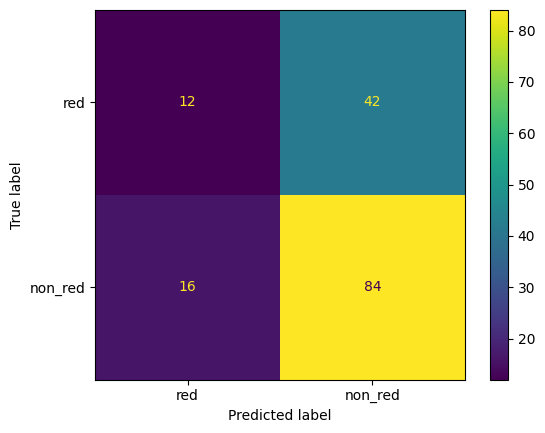

Training layers:  12%|█▏        | 5/41 [03:37<26:08, 43.58s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 5----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.6460 (0.551 sec) Accuracy: 0.651



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.6538,  Accuracy: 0.636



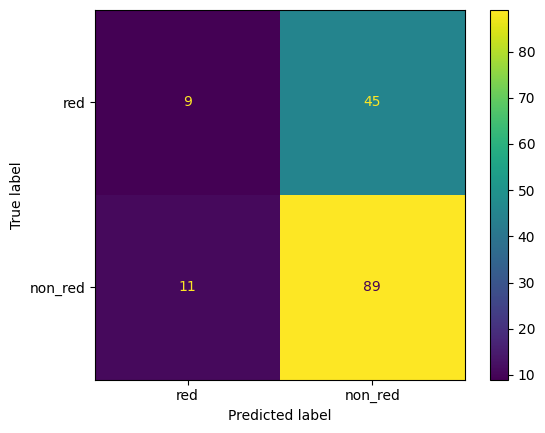

Training layers:  15%|█▍        | 6/41 [04:21<25:32, 43.77s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 6----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 16.7804 (0.545 sec) Accuracy: 0.664



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6073,  Accuracy: 0.649



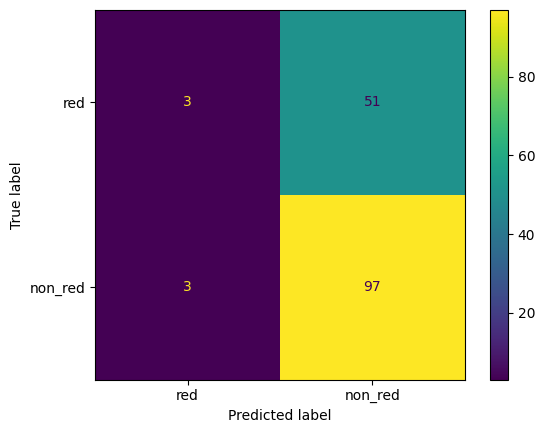

Training layers:  17%|█▋        | 7/41 [05:04<24:46, 43.71s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 7----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 28.0552 (0.522 sec) Accuracy: 0.662



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 23.3191,  Accuracy: 0.662



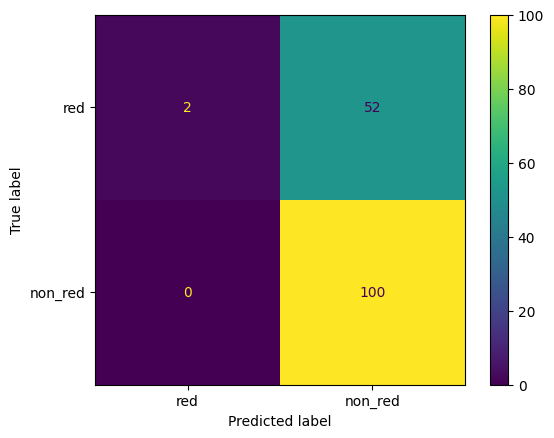

Training layers:  20%|█▉        | 8/41 [05:47<23:49, 43.32s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 8----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.6270 (0.546 sec) Accuracy: 0.670



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.6376,  Accuracy: 0.662



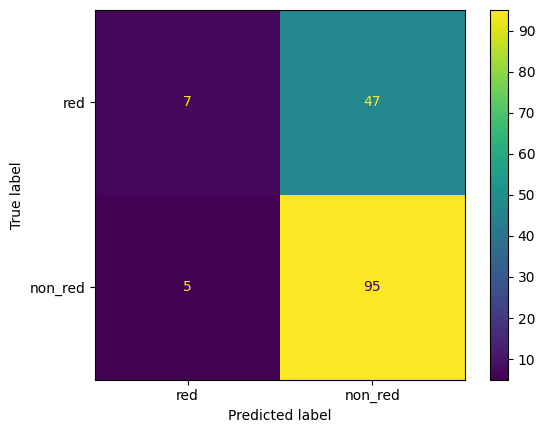

Training layers:  22%|██▏       | 9/41 [06:29<22:55, 42.97s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 9----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 16.4418 (0.533 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6558,  Accuracy: 0.662



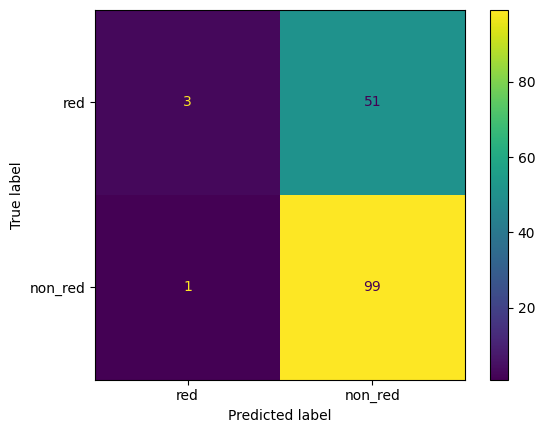

Training layers:  24%|██▍       | 10/41 [07:12<22:12, 43.00s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 10----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 15.6276 (0.519 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6049,  Accuracy: 0.662



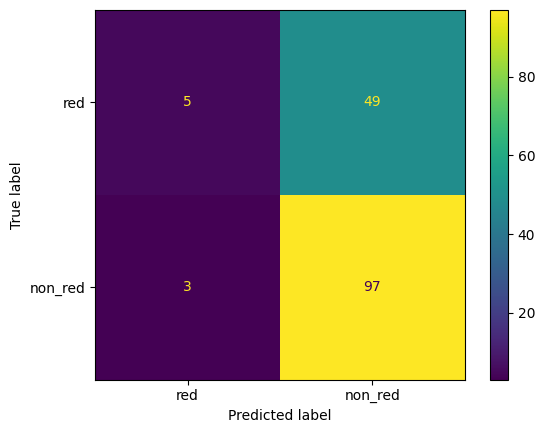

Training layers:  27%|██▋       | 11/41 [07:55<21:29, 42.98s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 11----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 10.8140 (0.528 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 9.3534,  Accuracy: 0.649



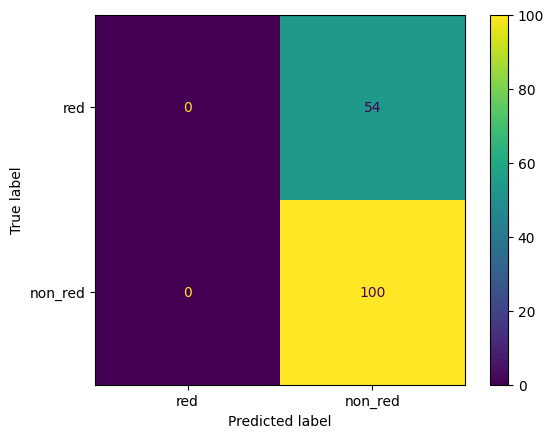

Training layers:  29%|██▉       | 12/41 [08:38<20:45, 42.93s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 12----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.6367 (0.513 sec) Accuracy: 0.668



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.6337,  Accuracy: 0.656



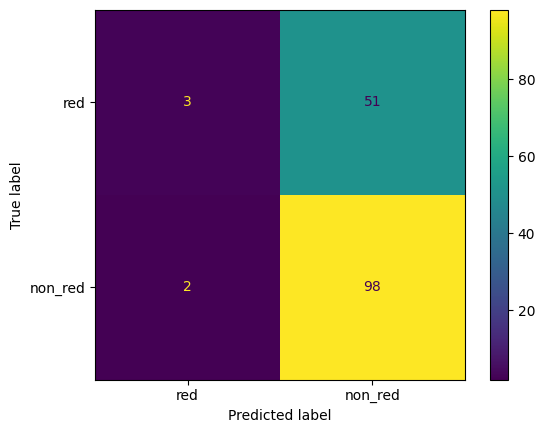

Training layers:  32%|███▏      | 13/41 [09:21<20:01, 42.91s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 13----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 48.1389 (0.528 sec) Accuracy: 0.371



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 46.8057,  Accuracy: 0.331



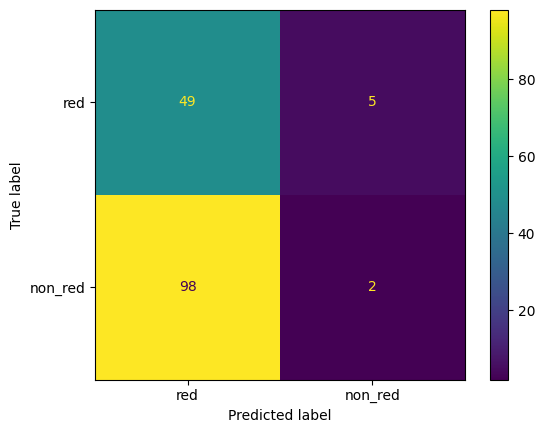

Training layers:  34%|███▍      | 14/41 [10:03<19:15, 42.79s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 14----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 31.4421 (0.552 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 31.8323,  Accuracy: 0.331



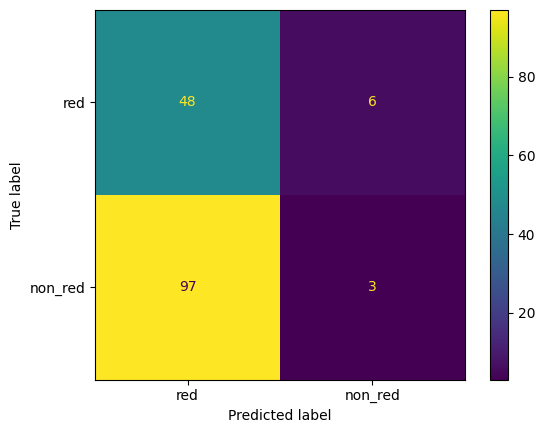

Training layers:  37%|███▋      | 15/41 [10:47<18:37, 43.00s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 15----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 61.0908 (0.556 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 63.0426,  Accuracy: 0.318



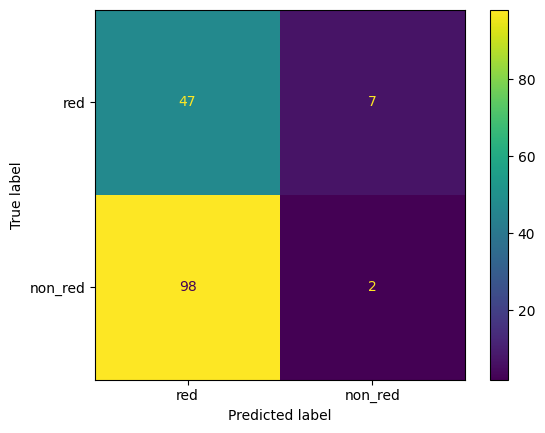

Training layers:  39%|███▉      | 16/41 [11:31<18:04, 43.39s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 16----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 34.4230 (0.540 sec) Accuracy: 0.662



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 30.5611,  Accuracy: 0.675



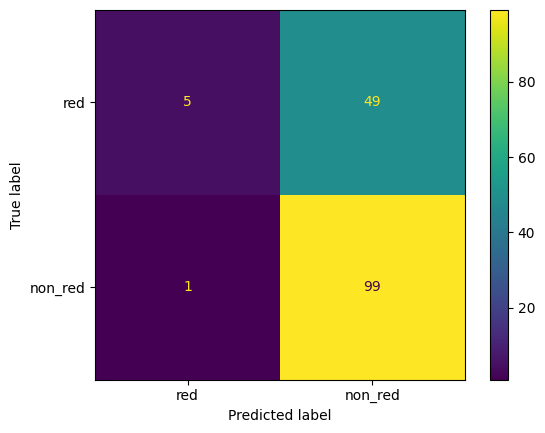

Training layers:  41%|████▏     | 17/41 [12:15<17:22, 43.43s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 17----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 48.3186 (0.558 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 46.8074,  Accuracy: 0.318



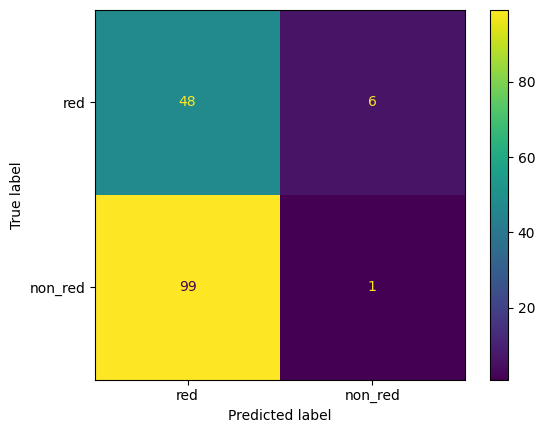

Training layers:  44%|████▍     | 18/41 [12:59<16:46, 43.74s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 18----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 62.6060 (0.561 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 63.0429,  Accuracy: 0.331



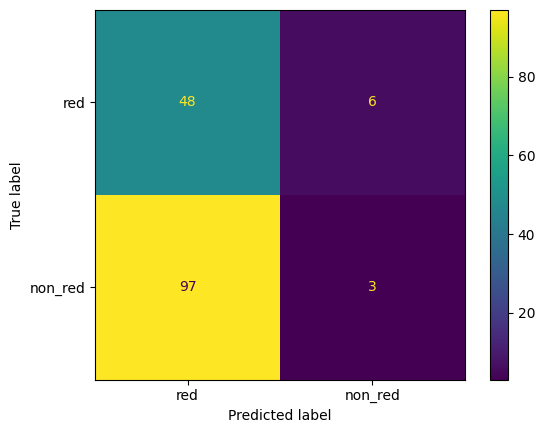

Training layers:  46%|████▋     | 19/41 [13:43<16:03, 43.79s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 19----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 17.3472 (0.569 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6120,  Accuracy: 0.662



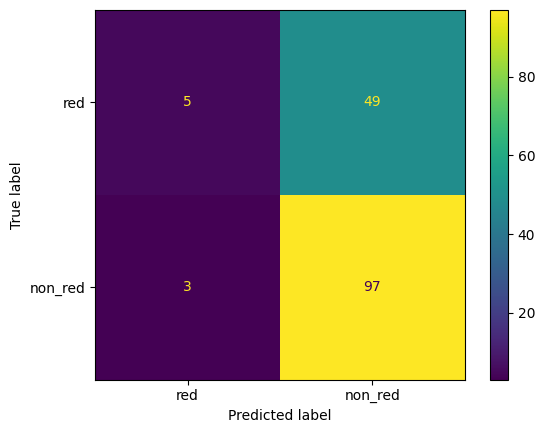

Training layers:  49%|████▉     | 20/41 [14:26<15:15, 43.58s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 20----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 47.9384 (0.520 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 46.8068,  Accuracy: 0.331



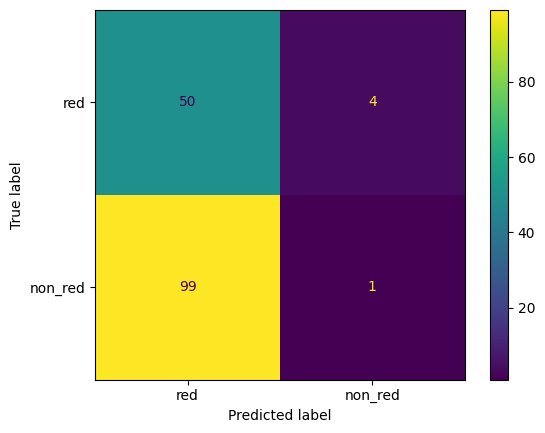

Training layers:  51%|█████     | 21/41 [15:11<14:38, 43.92s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 21----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 18.1411 (0.551 sec) Accuracy: 0.664



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6366,  Accuracy: 0.649



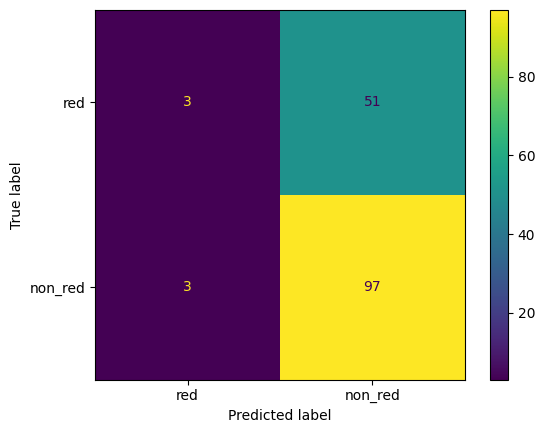

Training layers:  54%|█████▎    | 22/41 [15:55<13:58, 44.16s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 22----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 47.7458 (0.584 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 46.8000,  Accuracy: 0.351



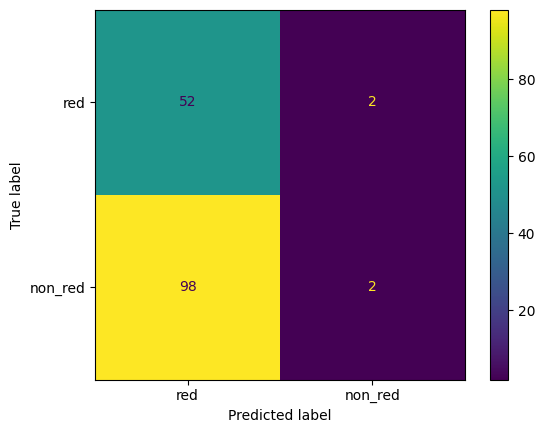

Training layers:  56%|█████▌    | 23/41 [16:41<13:23, 44.65s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 23----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 63.3614 (0.571 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 63.0347,  Accuracy: 0.344



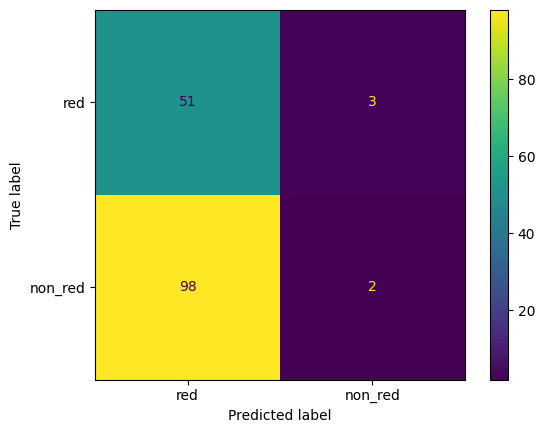

Training layers:  59%|█████▊    | 24/41 [17:27<12:45, 45.02s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 24----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 16.5670 (0.561 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6046,  Accuracy: 0.669



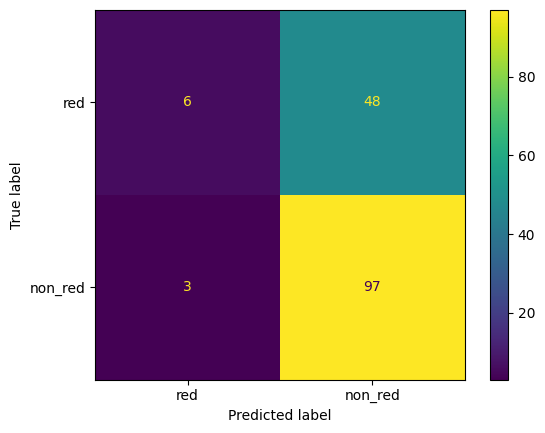

Training layers:  61%|██████    | 25/41 [18:13<12:01, 45.12s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 25----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 33.2655 (0.577 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 30.5669,  Accuracy: 0.669



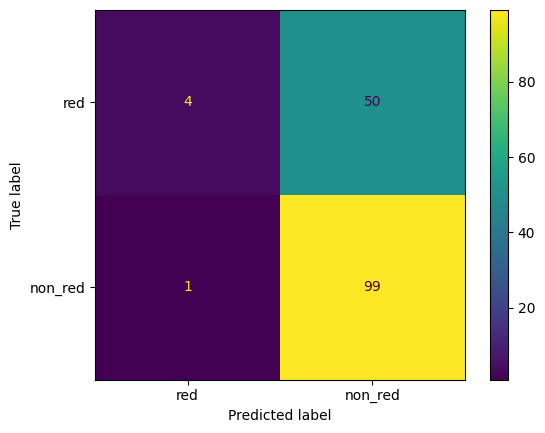

Training layers:  63%|██████▎   | 26/41 [18:58<11:18, 45.21s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 26----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 16.9464 (0.574 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.5974,  Accuracy: 0.669



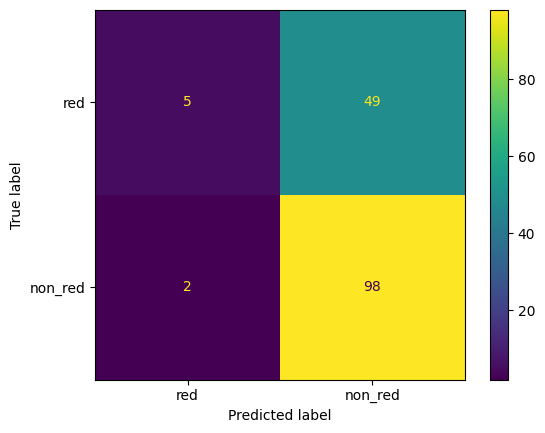

Training layers:  66%|██████▌   | 27/41 [19:43<10:32, 45.18s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 27----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 17.3469 (0.574 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6240,  Accuracy: 0.656



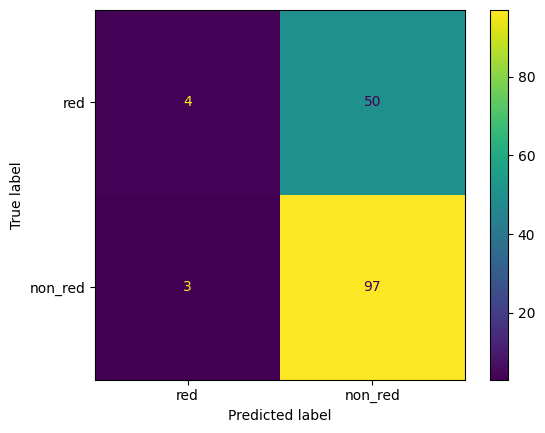

Training layers:  68%|██████▊   | 28/41 [20:28<09:47, 45.20s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 28----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 32.8857 (0.556 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 30.5668,  Accuracy: 0.669



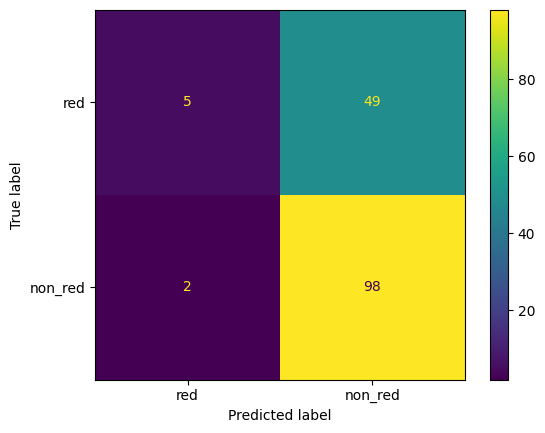

Training layers:  71%|███████   | 29/41 [21:14<09:02, 45.25s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 29----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 15.9856 (0.557 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.5947,  Accuracy: 0.669



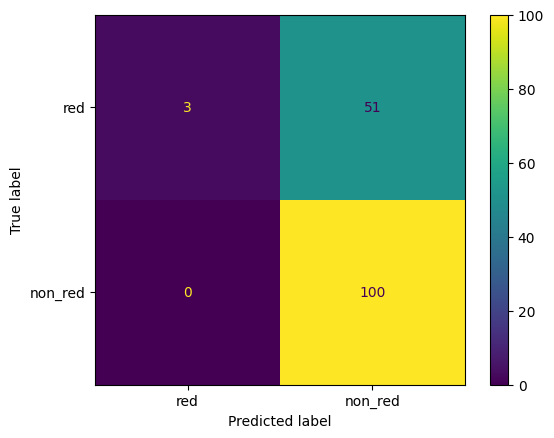

Training layers:  73%|███████▎  | 30/41 [21:59<08:16, 45.15s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 30----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 33.6442 (0.556 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 30.5663,  Accuracy: 0.669



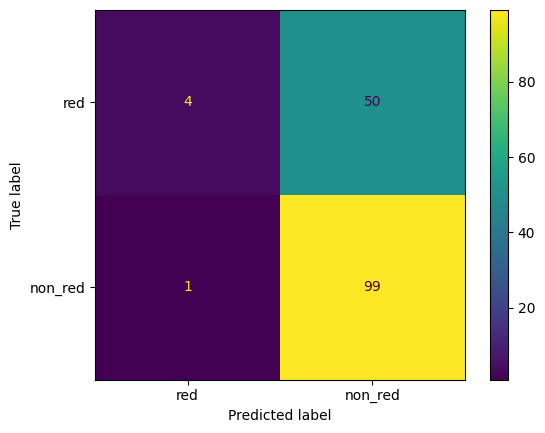

Training layers:  76%|███████▌  | 31/41 [22:44<07:32, 45.28s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 31----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 46.6897 (0.580 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 45.5423,  Accuracy: 0.357



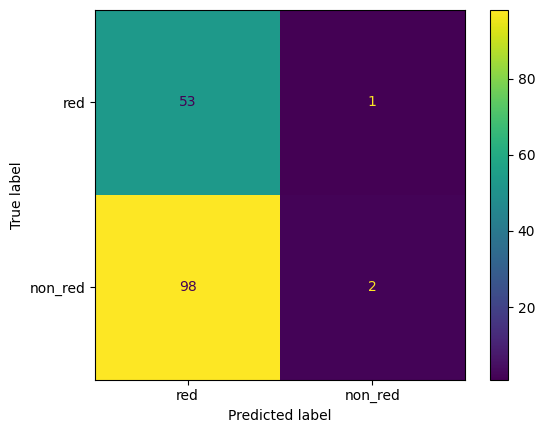

Training layers:  78%|███████▊  | 32/41 [23:31<06:51, 45.74s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 32----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 17.6544 (0.560 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.7037,  Accuracy: 0.662



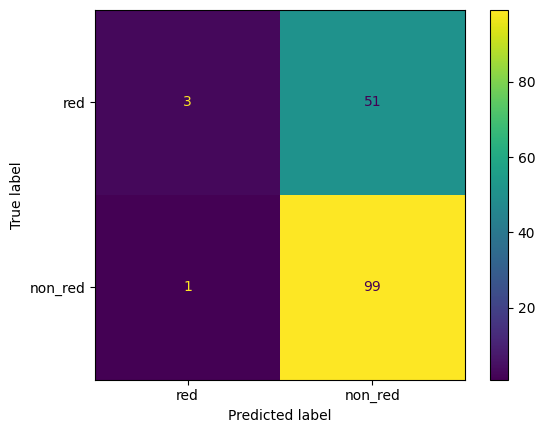

Training layers:  80%|████████  | 33/41 [24:16<06:05, 45.67s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 33----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 16.9603 (0.569 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6153,  Accuracy: 0.656



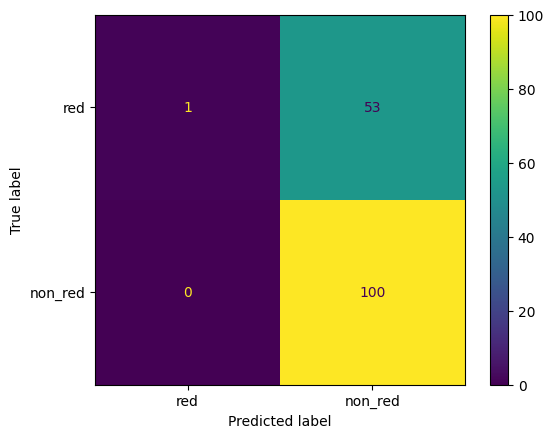

Training layers:  83%|████████▎ | 34/41 [25:02<05:19, 45.66s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 34----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 32.8843 (0.577 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 30.5723,  Accuracy: 0.675



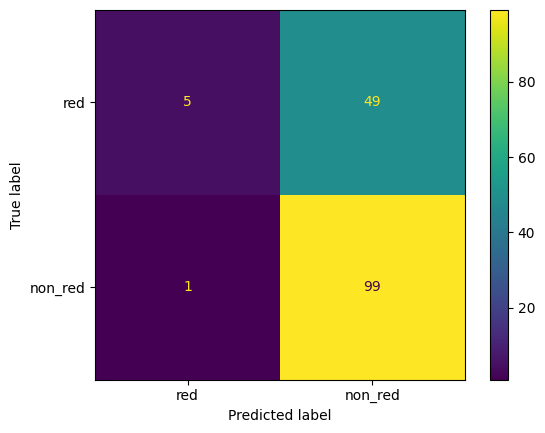

Training layers:  85%|████████▌ | 35/41 [25:48<04:33, 45.66s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 35----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 16.3702 (0.576 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6142,  Accuracy: 0.669



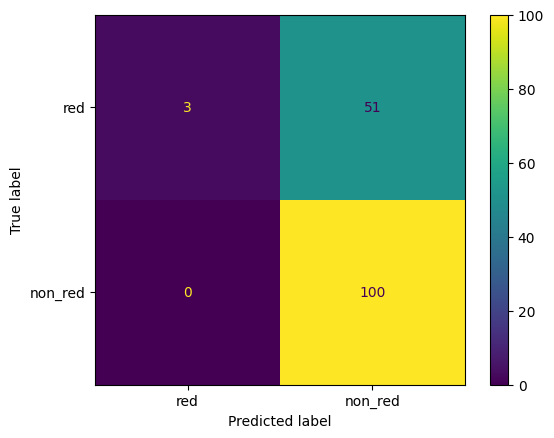

Training layers:  88%|████████▊ | 36/41 [26:33<03:48, 45.63s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 36----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 63.7386 (0.568 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 63.0432,  Accuracy: 0.344



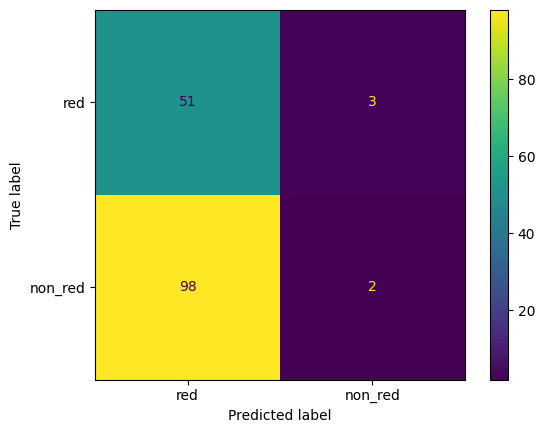

Training layers:  90%|█████████ | 37/41 [27:19<03:02, 45.64s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 37----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 47.9320 (0.577 sec) Accuracy: 0.373



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 46.8393,  Accuracy: 0.344



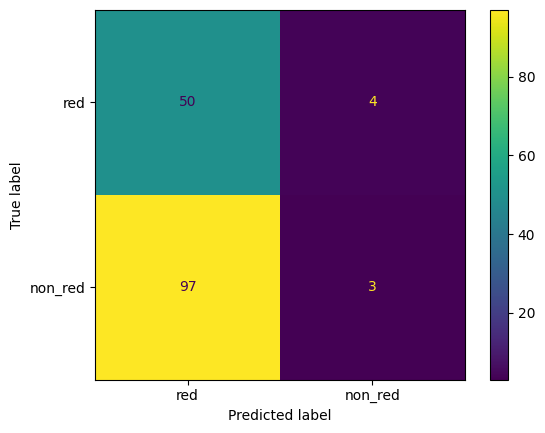

Training layers:  93%|█████████▎| 38/41 [28:05<02:16, 45.66s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 38----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 33.7791 (0.570 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 30.2510,  Accuracy: 0.656



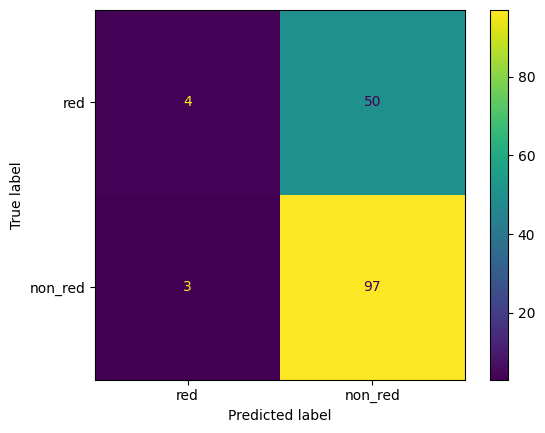

Training layers:  95%|█████████▌| 39/41 [28:50<01:31, 45.68s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 39----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 16.8025 (0.571 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 15.6746,  Accuracy: 0.662



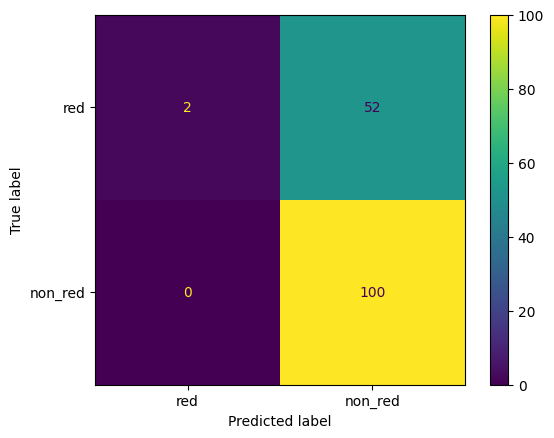

Training layers:  98%|█████████▊| 40/41 [29:36<00:45, 45.62s/it]

Decayed: {'proj.0.bias', 'proj.0.weight'}
----------------------------------------Layer 40----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Train set: Average loss: 0.6302 (0.576 sec) Accuracy: 0.666



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test set: Average loss: 0.6648,  Accuracy: 0.662



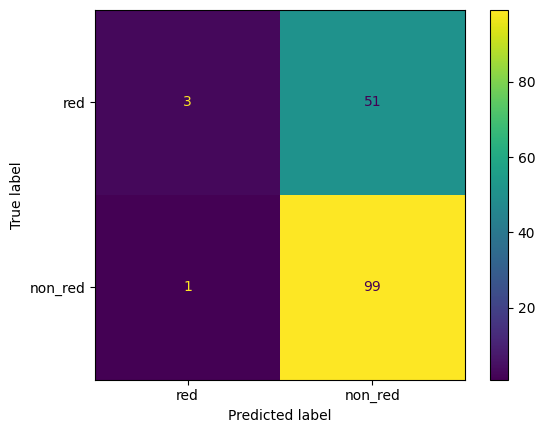

Training layers: 100%|██████████| 41/41 [30:22<00:00, 44.45s/it]


In [15]:
one_hot = True

label_to_id = {
    f"{COLOR}": 1,
    f"non_{COLOR}": 0,
}

uncertainty = False

accs = []
final_accs = []
train_accs = []
for i in tqdm(range(0, 41), desc="Training layers"):
    trainer_config = TrainerConfig()
    probe = LinearProbeClassification(
        probe_class=len(label_to_id.keys()),
        device="cuda",
        input_dim=5120,
        logistic=True,
    )
    optimizer, scheduler = probe.configure_optimizers(trainer_config)
    best_acc = 0
    max_epoch = 50
    verbosity = False
    layer_num = i
    print("-" * 40 + f"Layer {layer_num}" + "-" * 40)
    for epoch in range(1, max_epoch + 1):
        if epoch == max_epoch:
            verbosity = True
        # Get the train results from training of each epoch
        if uncertainty:
            train_results = train(
                probe,
                device,
                train_loader,
                optimizer,
                epoch,
                loss_func=loss_func,
                verbose_interval=None,
                verbose=verbosity,
                layer_num=layer_num,
                return_raw_outputs=True,
                epoch_num=epoch,
                num_classes=len(label_to_id.keys()),
            )
            test_results = test(
                probe,
                device,
                test_loader,
                loss_func=loss_func,
                return_raw_outputs=True,
                verbose=verbosity,
                layer_num=layer_num,
                scheduler=scheduler,
                epoch_num=epoch,
                num_classes=len(label_to_id.keys()),
            )
        else:
            train_results = train(
                probe,
                device,
                train_loader,
                optimizer,
                epoch,
                loss_func=loss_func,
                verbose_interval=None,
                verbose=verbosity,
                layer_num=layer_num,
                return_raw_outputs=True,
                one_hot=one_hot,
                num_classes=len(label_to_id.keys()),
            )
            test_results = test(
                probe,
                device,
                test_loader,
                loss_func=loss_func,
                return_raw_outputs=True,
                verbose=verbosity,
                layer_num=layer_num,
                scheduler=scheduler,
                one_hot=one_hot,
                num_classes=len(label_to_id.keys()),
            )

        if test_results[1] > best_acc:
            best_acc = test_results[1]
            torch.save(
                probe.state_dict(),
                f"probe_checkpoints/control_probe/{dict_name}_probe_at_layer_{layer_num}.pth",
            )
    torch.save(
        probe.state_dict(),
        f"probe_checkpoints/control_probe/{dict_name}_probe_at_layer_{layer_num}_final.pth",
    )

    accs.append(best_acc)
    final_accs.append(test_results[1])
    train_accs.append(train_results[1])
    cm = confusion_matrix(test_results[3], test_results[2])
    cm_display = ConfusionMatrixDisplay(
        cm, display_labels=label_to_id.keys()
    ).plot()
    plt.show()

    accuracy_dict[dict_name].append(accs)
    accuracy_dict[dict_name + "_final"].append(final_accs)
    accuracy_dict[dict_name + "_train"].append(train_accs)

    with open(
        "probe_checkpoints/control_probe_experiment.pkl", "wb"
    ) as outfile:
        pickle.dump(accuracy_dict, outfile)
# del dataset, train_dataset, test_dataset, train_loader, test_loader
torch.cuda.empty_cache()

(0.0, 1.0)

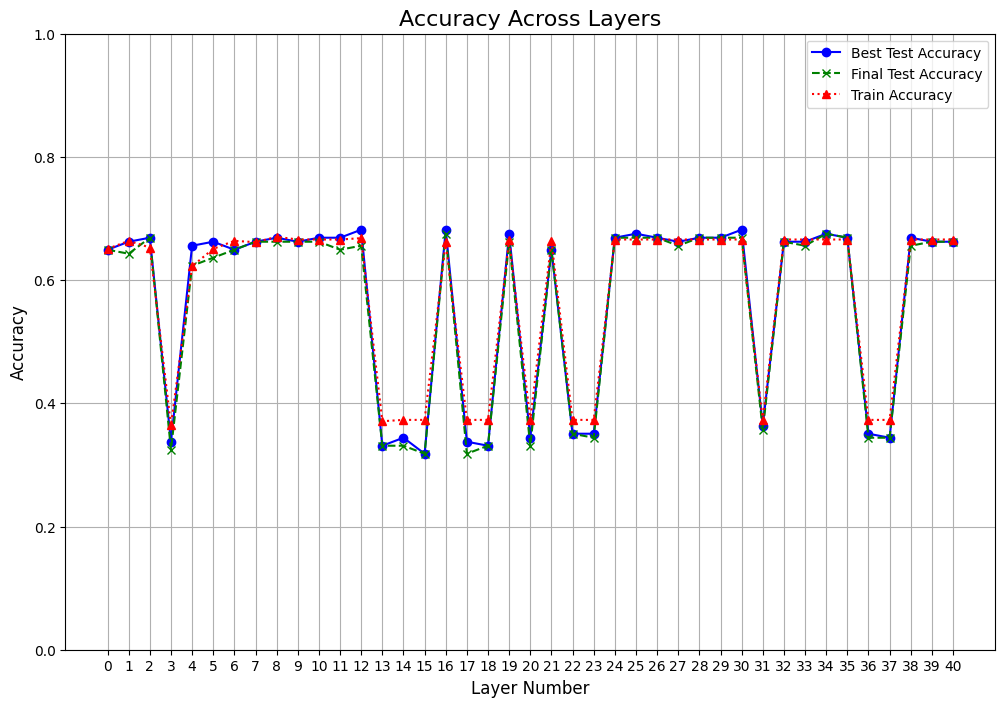

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the x-axis values (layer numbers)
layers = np.arange(len(accs))

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(
    layers,
    accs,
    label="Best Test Accuracy",
    marker="o",
    linestyle="-",
    color="b",
)

# Plot final_accs
plt.plot(
    layers,
    final_accs,
    label="Final Test Accuracy",
    marker="x",
    linestyle="--",
    color="g",
)

# Plot train_accs
plt.plot(
    layers,
    train_accs,
    label="Train Accuracy",
    marker="^",
    linestyle=":",
    color="r",
)

# Add labels and title
plt.title("Accuracy Across Layers", fontsize=16)
plt.xlabel("Layer Number", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(layers)
plt.grid(True)
plt.legend(fontsize=10)
plt.ylim(0, 1.0)